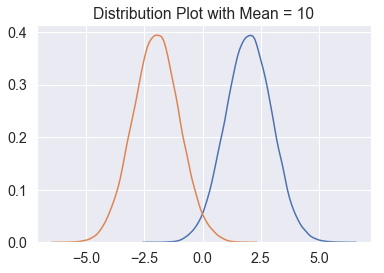

In [1]:
import numpy as np

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=1.3)

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(100000, 2, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
sns.distplot(list(zip(*class_one))[0], hist=False)
sns.distplot(list(zip(*class_neg_one))[0], hist=False)
plt.title("Distribution Plot with Mean = 10")
plt.show()

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from scipy.stats import entropy

def CART_estimate_posterior(X, y, n_trees = 300, bootstrap = True, depth = 30):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = depth)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    neg_one_class, one_class = np.hsplit(probs, 2)
    X_labels = X.reshape(-1)
    order = np.argsort(X_labels)
    one_class = one_class[order].flatten()
    neg_one_class = neg_one_class[order].flatten()
    
    X_labels = np.sort(X_labels)
    return X_labels, neg_one_class, one_class

#X, y = get_sample(10000, 1, 1)
#X_labels_cart, neg_one_class_cart, one_class_cart = CART_estimate_posterior(np.array(X).reshape(-1, 1), y, 300)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

def honesty_estimate_posterior(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))

        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].item()).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    neg_one_class, one_class = np.hsplit(probs, 2)
    X_labels = X.reshape(-1)
    order = np.argsort(X_labels)
    one_class = one_class[order].flatten()
    neg_one_class = neg_one_class[order].flatten()
    
    X_labels = np.sort(X_labels)
    return X_labels, neg_one_class, one_class

np.warnings.filterwarnings('ignore')


In [4]:
np.warnings.filterwarnings('ignore')
def cef_estimate_posterior(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].item()).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    neg_one_class, one_class = np.hsplit(probs, 2)
    X_labels = X.reshape(-1)
    order = np.argsort(X_labels)
    one_class = one_class[order].flatten()
    neg_one_class = neg_one_class[order].flatten()
    
    X_labels = np.sort(X_labels)
    return X_labels, neg_one_class, one_class
X, y = get_sample(1000, 1, 1)
X = np.array(X).reshape(-1, 1)
X_labels_cef, neg_one_class_cef, one_class_cef = cef_estimate_posterior(X, y, 300, .32)


In [5]:
from tqdm import tqdm_notebook

def get_posteriors_variance(n, mean, trials):
    honest_one = []
    cef_one = []
    cart_one = []
    X_samples = []
    for i in tqdm_notebook(range(trials)):
        X, y = get_sample(n, mean, 1)
        X = np.array(X).reshape(-1, 1)
        X_samples.append(X)
        X_labels, neg_one_cart, one_cart = CART_estimate_posterior(X, y, 300, .32)
        X_labels, neg_one_honest, one_honest = honesty_estimate_posterior(X, y, 300, .32)
        X_labels, neg_one_cef, one_cef = cef_estimate_posterior(X, y, 300, .32)
        honest_one.append(one_honest)
        cef_one.append(one_cef)
        cart_one.append(one_cart)
        
    return X_samples, cart_one, honest_one, cef_one


In [12]:
X_samples, cart_one, honest_one, cef_one = get_posteriors_variance(5000, 1, 500)

In [4]:
import pickle
#pickle.dump({"X_samples": X_samples, "cart_one": cart_one, "honest_one": honest_one, "cef_one": cef_one}, open("posterior_var_500.p", "wb"))
data = pickle.load(open("cache/posterior_var_500.p", "rb"))
X_samples = data["X_samples"]
cart_one = data["cart_one"]
honest_one = data["honest_one"]
cef_one = data["cef_one"]


In [5]:
var_cart_one = np.var(np.array(cart_one), axis = 0)
var_honest_one = np.var(np.array(honest_one), axis = 0)
var_cef_one = np.var(np.array(cef_one), axis = 0)

In [6]:
sorted_x_samples = []
for x in X_samples:
    sorted_x_samples.append(np.sort(x, axis = None))
avg_X_samples = np.mean(np.array(sorted_x_samples), axis = 0)
avg_X_samples = np.sort(avg_X_samples, axis = 0)

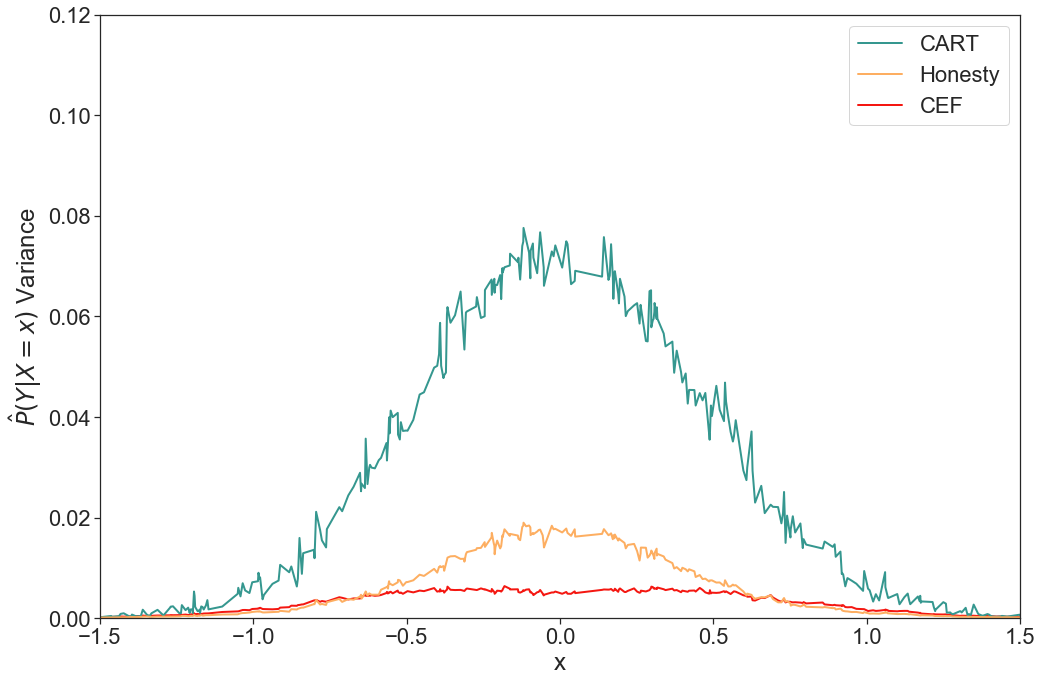

In [8]:
sns.set(font_scale = 2)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]

indices = np.sort(np.random.choice(5000, 500, replace = False))

line_cef, = plt.plot(avg_X_samples[indices], var_cef_one.flatten()[indices], label = "CEF", linewidth = 2, color = "#F41711")

line_cart, = plt.plot(avg_X_samples[indices], var_cart_one.flatten()[indices], label = "CART", linewidth = 2, color = "#35978f")

line_honest, = plt.plot(avg_X_samples[indices], var_honest_one.flatten()[indices], label = "Honesty", linewidth = 2, color = "#fdae61")

plt.xlabel("x")
plt.ylabel(r"$\hat P(Y|X = x)$ Variance")
plt.ylim(ymin = 0)
plt.ylim(ymax = .12)
plt.xlim(xmin = -1.5)
plt.xlim(xmax = 1.5)
plt.legend(handles=[line_cart, line_honest, line_cef,])
#plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.tight_layout()
plt.savefig("posterior_var_x_500.png")
plt.show()

# Posterior Plots

In [10]:
X, y = get_sample(10000, 1, 1)
X = np.array(X).reshape(-1, 1)
X_labels_cart, neg_one_class_cart, one_class_cart = CART_estimate_posterior(np.array(X).reshape(-1, 1), y, 300)

In [33]:
X_labels_honest, neg_one_class_honest, one_class_honest = honesty_estimate_posterior(X, y, 300, .32)

In [39]:
X_labels_cef, neg_one_class_cef, one_class_cef = cef_estimate_posterior(X, y, 300, .32)

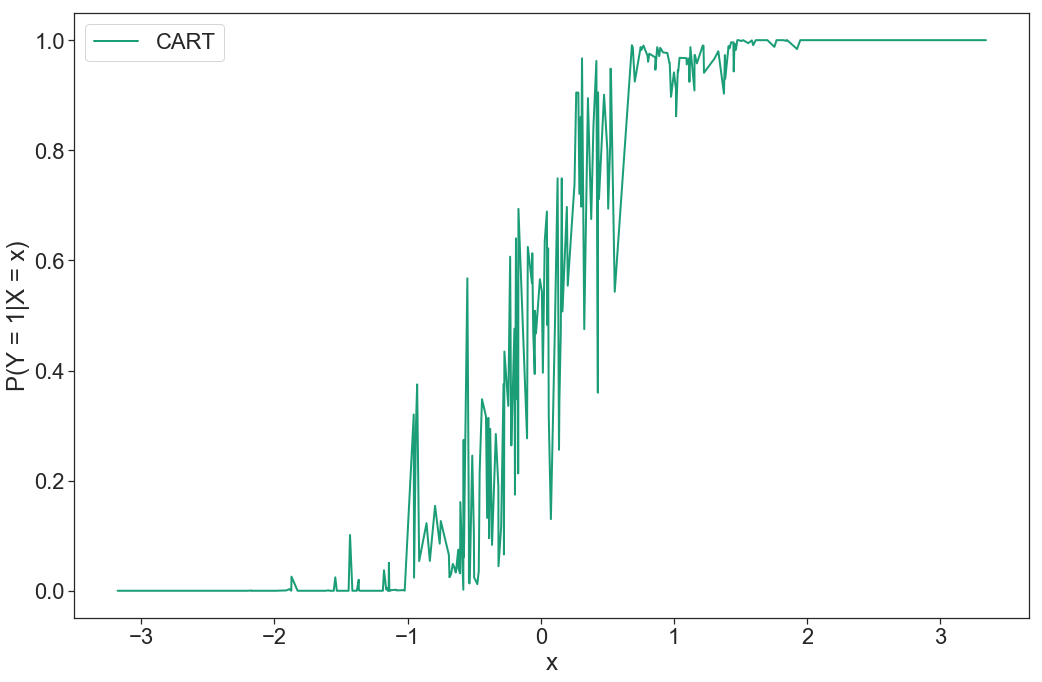

In [37]:
indices = np.sort(np.random.choice(10000, 300, replace = False))
sns.set(font_scale = 2)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]

line_cart, = plt.plot(X_labels_cart[indices], one_class_cart[indices], label = "CART", linewidth = 2, color = "#1b9e77")
plt.xlabel("x")
plt.ylabel("P(Y = 1|X = x)")
#plt.ylim(ymin = 0)
#plt.ylim(ymax = .9)
plt.legend(handles=[line_cart])
plt.tight_layout()
plt.savefig("cart_posterior.png")
plt.show()

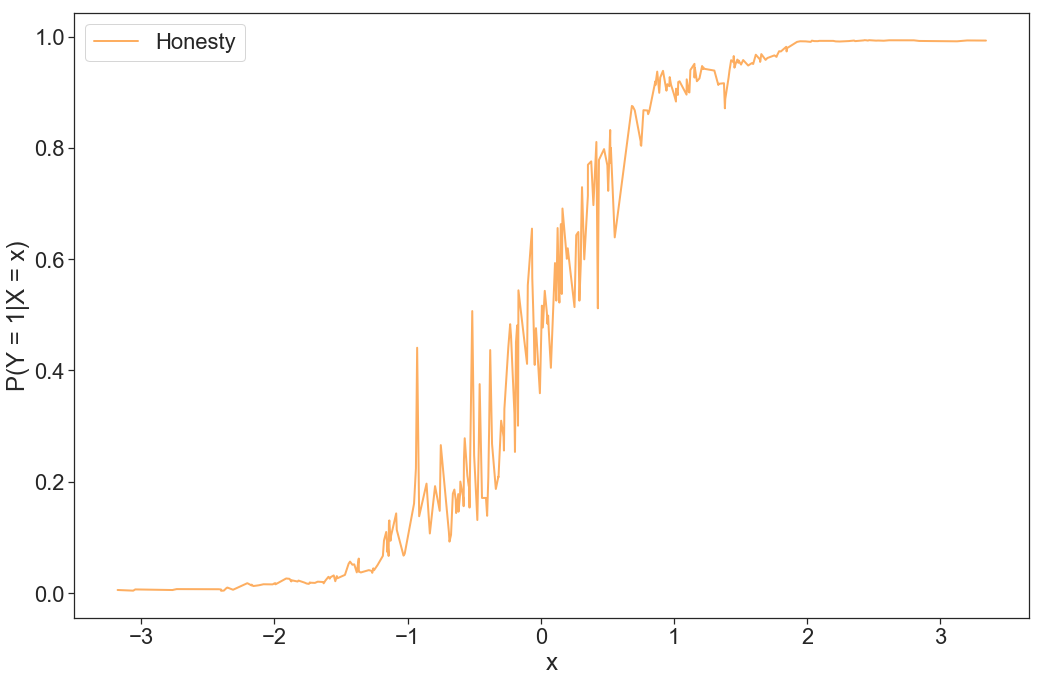

In [38]:
line_honesty, = plt.plot(X_labels_honest[indices], one_class_honest[indices], label = "Honesty", color = "#fdae61", linewidth = 2)
plt.xlabel("x")
plt.ylabel("P(Y = 1|X = x)")
#plt.ylim(ymin = 0)
#plt.ylim(ymax = .9)
plt.legend(handles=[line_honesty])
plt.tight_layout()
plt.savefig("honesty_posterior.png")
plt.show()

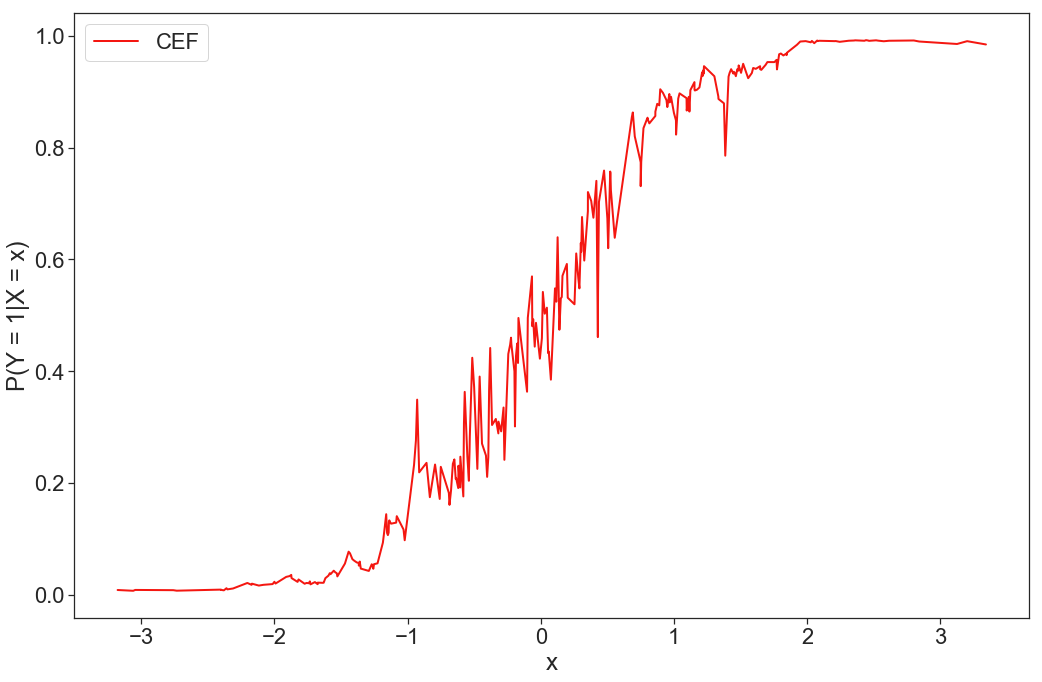

In [41]:
line_cef, = plt.plot(X_labels_cef[indices], one_class_cef[indices], label = "CEF", color = "#F41711", linewidth = 2)
plt.xlabel("x")
plt.ylabel("P(Y = 1|X = x)")
#plt.ylim(ymin = 0)
#plt.ylim(ymax = .9)
plt.legend(handles=[line_cef])
plt.tight_layout()
plt.savefig("cef_posterior.png")
plt.show()

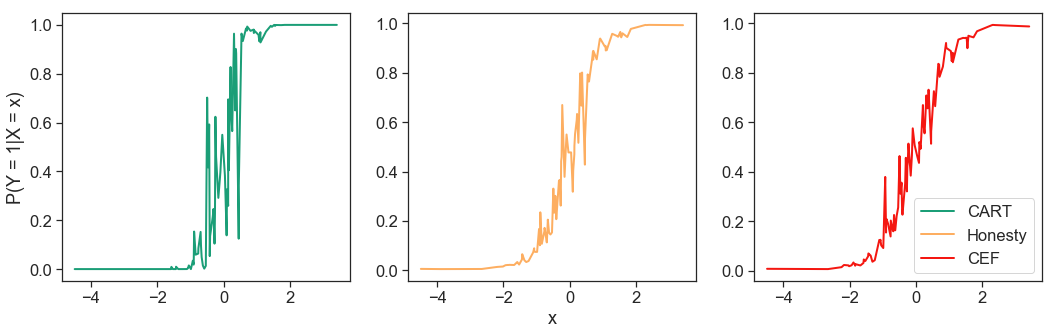

In [67]:
sns.set(font_scale = 1.5)
sns.set_style("ticks")
indices = np.sort(np.random.choice(10000, 100, replace = False))

plt.rcParams['figure.figsize'] = [15, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
line_cart, = ax1.plot(X_labels_cart[indices], one_class_cart[indices], label = "CART", linewidth = 2, color = "#1b9e77")
line_honest, = ax2.plot(X_labels_honest[indices], one_class_honest[indices], label = "Honesty", color = "#fdae61", linewidth = 2)
line_cef, = ax3.plot(X_labels_cef[indices], one_class_cef[indices], label = "CEF", color = "#F41711", linewidth = 2)
plt.legend(handles=[line_cart, line_honest, line_cef,], loc = 'lower right')
ax2.set_xlabel("x")
ax1.set_ylabel("P(Y = 1|X = x)")
#plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
fig.tight_layout()
plt.savefig("posterior_combined.png")
plt.show()